In [2]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt 

In [3]:
data = pd.read_csv('News.csv', index_col=0)
data.head()

,title,text,subject,date,class
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0


# Data preprocessing

The shape of the dataset can be found by the below code.

In [4]:
data.shape

(44919, 5)

As the title, subject and date column will not going to be helpful in identification of the news. So, we can drop these column.

In [5]:
data = data.drop(["title", "subject","date"], axis=1)

Now, we have to check if there is any null value (we will drop those rows)

In [6]:
data.isnull().sum()

text     0
class    0
dtype: int64

So there is no null value.

 Now we have to shuffle the dataset to prevent the model to get bias. After that we will reset the index and then drop it. Because index column is not useful to us.

In [7]:
# Shuffling
data = data.sample(frac=1)
data.reset_index(inplace=True)
data.drop(["index"], axis=1, inplace=True)


Now Let’s explore the unique values in the each category using below code.

<Axes: xlabel='class', ylabel='count'>

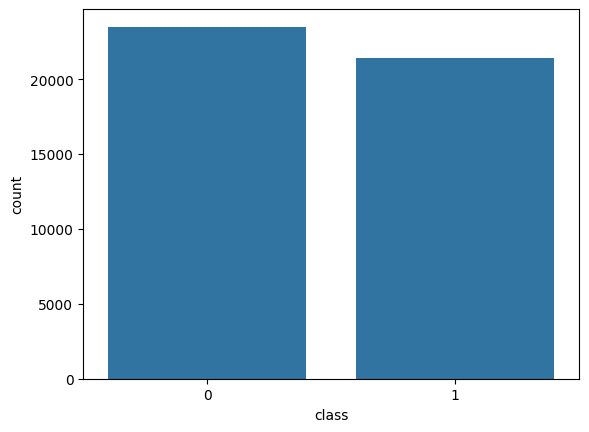

In [8]:
sns.countplot(data=data,x='class',order=data['class'].value_counts().index)

Preprocessing and analysis of News 

Firstly we will remove all the stopwords, punctuations and any irrelevant spaces from the text. For that NLTK Library is required and some of it’s module need to be downloaded. So, for that run the below code.

In [9]:
from tqdm import tqdm
import re
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Once we have all the required modules, we can create a function name preprocess text. This function will preprocess all the data given as input.

In [10]:
def preprocess_text(text_data):
    preprocessed_text = []
    
    for sentence in tqdm(text_data):
        sentence = re.sub(r'[^\w\s]', '', sentence)
        preprocessed_text.append(' '.join(token.lower()
                                  for token in str(sentence).split()
                                  if token not in stopwords.words('english')))

    return preprocessed_text


To implement the function in all the news in the text column, run the below command.

In [11]:
preprocessed_review = preprocess_text(data['text'].values)
data['text'] = preprocessed_review

  4%|▍         | 1816/44919 [03:29<1:23:01,  8.65it/s]


KeyboardInterrupt: 

Let’s visualize the WordCloud for fake and real news separately.

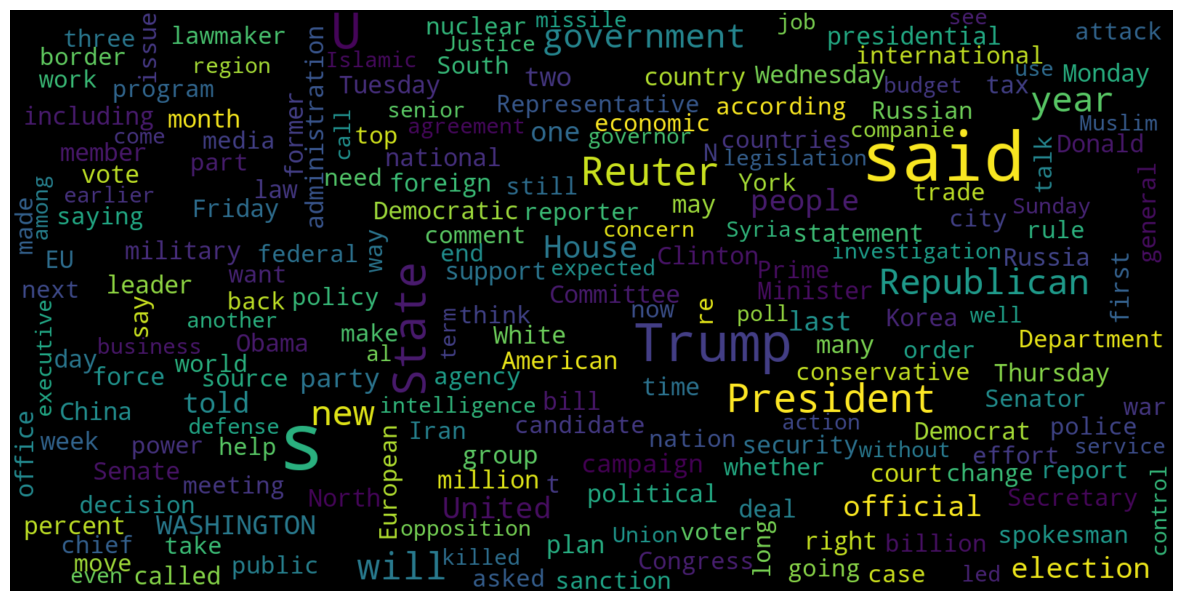

In [14]:
# Real
consolidated = ' '.join(
    word for word in data['text'][data['class'] == 1].astype(str))
wordCloud = WordCloud(width=1600,
                      height=800,
                      random_state=21,
                      max_font_size=110,
                      collocations=False)
plt.figure(figsize=(15, 10))
plt.imshow(wordCloud.generate(consolidated), interpolation='bilinear')
plt.axis('off')
plt.show()


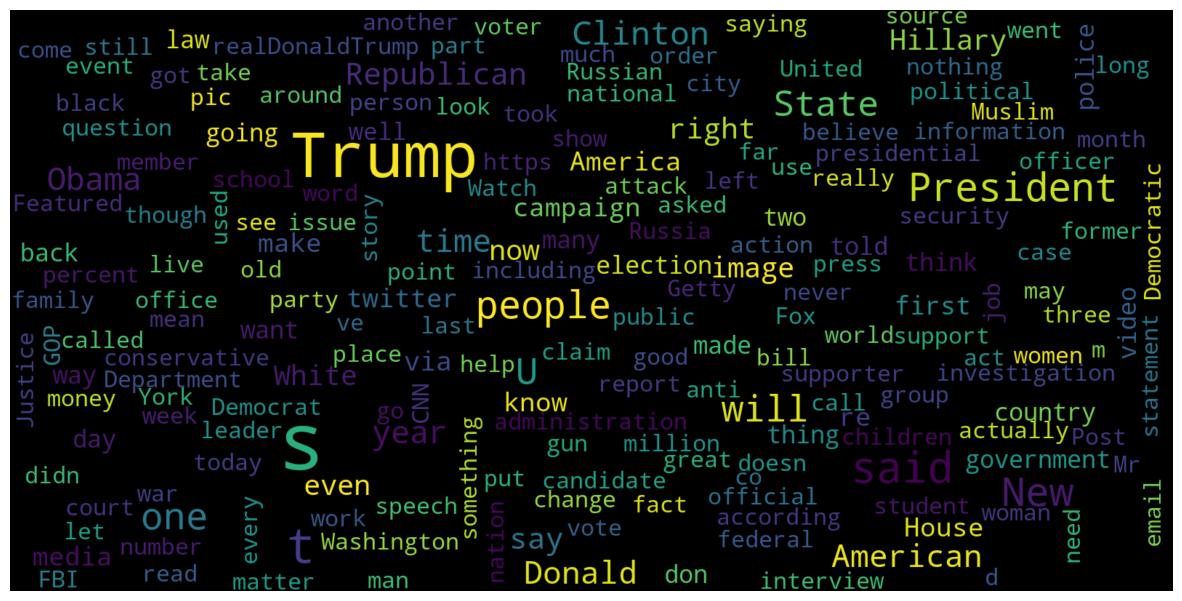

In [15]:
# Fake
consolidated = ' '.join(
    word for word in data['text'][data['class'] == 0].astype(str))
wordCloud = WordCloud(width=1600,
                      height=800,
                      random_state=21,
                      max_font_size=110,
                      collocations=False)
plt.figure(figsize=(15, 10))
plt.imshow(wordCloud.generate(consolidated), interpolation='bilinear')
plt.axis('off')
plt.show()


Now, Let’s plot the bargraph of the top 20 most frequent words.

<Axes: title={'center': 'Bar Chart of Top Words Frequency'}, xlabel='Top Words', ylabel='Count'>

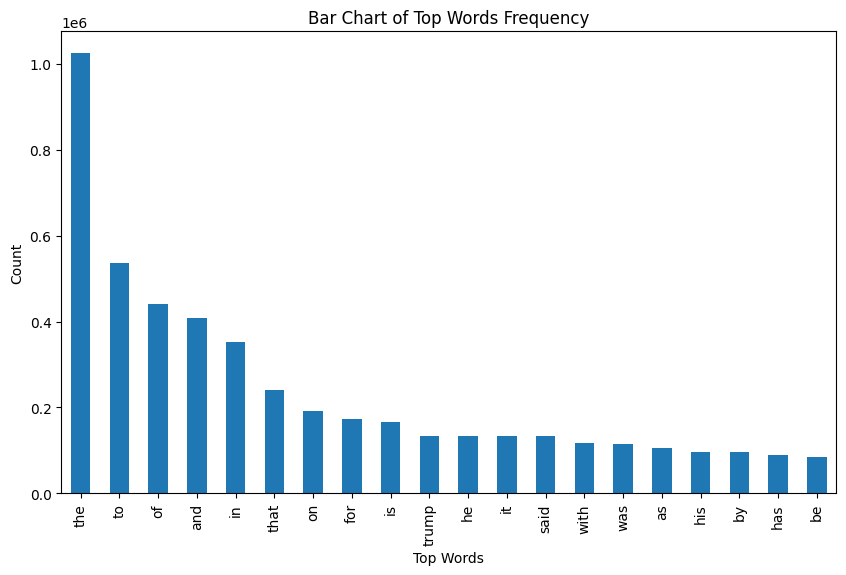

In [16]:
from sklearn.feature_extraction.text import CountVectorizer


def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx])
                  for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1],
                        reverse=True)
    return words_freq[:n]


common_words = get_top_n_words(data['text'], 20)
df1 = pd.DataFrame(common_words, columns=['Review', 'count'])

df1.groupby('Review').sum()['count'].sort_values(ascending=False).plot(
    kind='bar',
    figsize=(10, 6),
    xlabel="Top Words",
    ylabel="Count",
    title="Bar Chart of Top Words Frequency"
)


# Converting text into Vectors
Before converting the data into vectors, split it into train and test.

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

x_train, x_test, y_train, y_test = train_test_split(data['text'], 
                                                    data['class'], 
                                                    test_size=0.25)


Now we can convert the training data into vectors using TfidfVectorizer.

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorization = TfidfVectorizer()
x_train = vectorization.fit_transform(x_train)
x_test = vectorization.transform(x_test)


# Model training, Evaluation, and Prediction
Now, the dataset is ready to train the model.

For training we will use Logistic Regression and evaluate the prediction accuracy using accuracy_score.

In [19]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(x_train, y_train)

# testing the model 

print(accuracy_score(y_train, model.predict(x_train)))
print(accuracy_score(y_test, model.predict(x_test)))

0.9912137492950222
0.9854853072128228


Let’s train with Decision Tree Classifier. 

In [20]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier()
model.fit(x_train, y_train)

# testing the model
print(accuracy_score(y_train, model.predict(x_train)))
print(accuracy_score(y_test, model.predict(x_test)))

0.9999703167205913
0.9959038290293856


The confusion matrix for Decision Tree Classifier can be implemented with the code below.

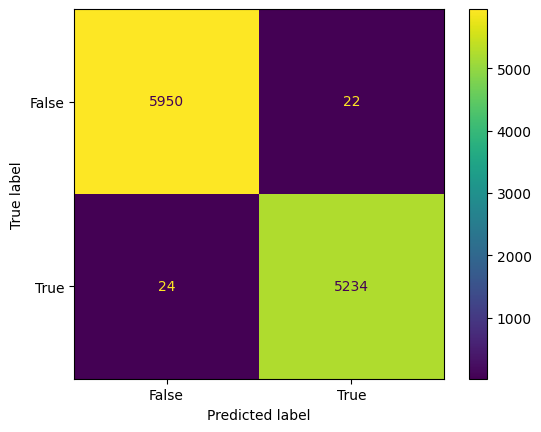

In [21]:
# Confusion matrix of Results from Decision Tree classification
from sklearn import metrics
cm = metrics.confusion_matrix(y_test, model.predict(x_test))

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
                                            display_labels=[False, True])

cm_display.plot()
plt.show()
